In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pocomc as pc
import mistsim as ms

In [2]:
NBINS = 24

### Load data

['ant_temp', 'freq', 'lst']


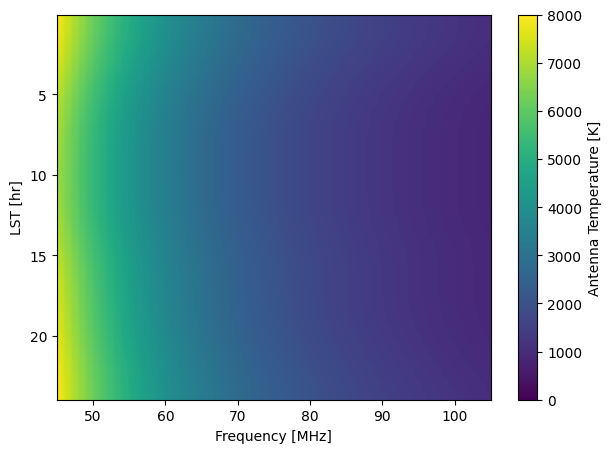

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Global signal

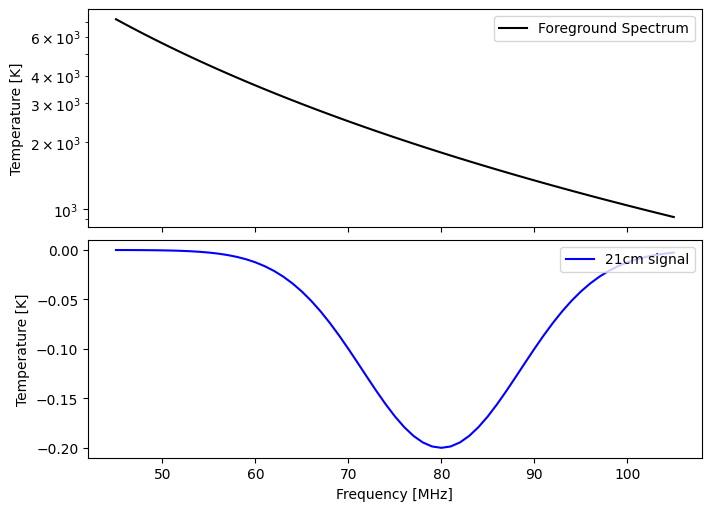

In [4]:
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = ms.utils.gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

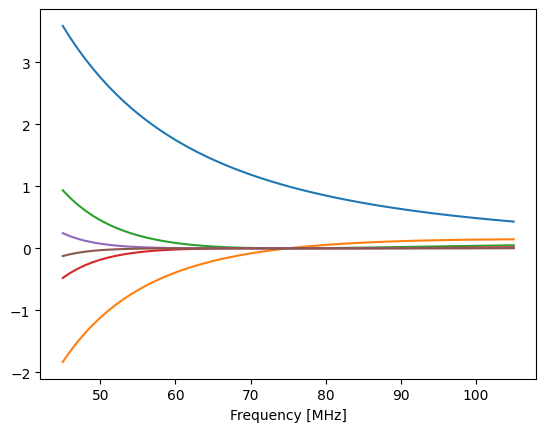

In [5]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

# Chromaticity correction

In [6]:
path = "CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
acp = path.replace(".hdf5", "_achromatic_75MHz.hdf5")
acp

'CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5'

['ant_temp', 'freq', 'lst']


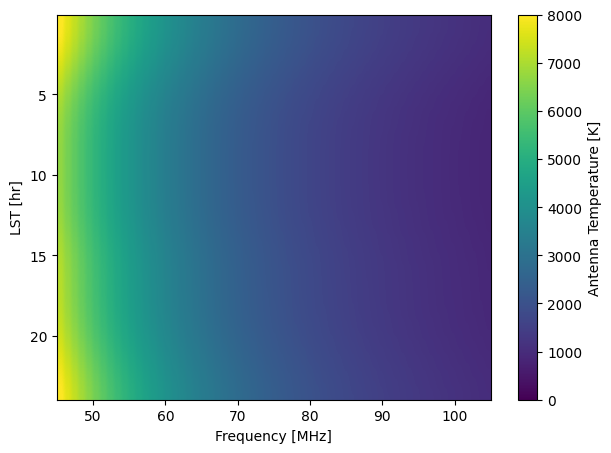

In [7]:
ac_temp = ms.utils.read_hdf5_convolution(f"../simulations/{acp}", print_key=True)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

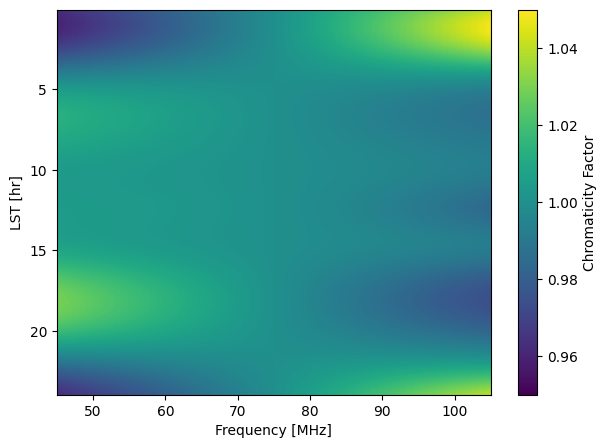

In [8]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [9]:
cut = nspec % NBINS
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, (ac_temp+TRUE_T21/chrom)))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
    chrom = chrom[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

True
(24, 61)


In [10]:
print(noise.shape)
print(sigma_inv.shape)
print(chrom_mean.shape)

(24, 61)
(24, 61)
(24, 61)


In [11]:
NFG = [4, 5]
BIN = 1
lst_bins = [ms.lstbin.LSTBin(freq, binned[BIN]+noise[BIN], np.diag(sigma_inv[BIN]), n, chrom=chrom_mean[BIN]) for n in NFG]

In [12]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
prior = ms.sampler.uniform_prior(bounds)
results = {}
for i, n in enumerate(NFG):
    results[n] = ms.run_sampler(prior, lst_bins[i], progress=True, vectorize=True, pool=None)

Iter: 48it [05:15,  6.56s/it, calls=2e+4, beta=1, logZ=-39.7, ESS=4.9e+3, acc=0.908, steps=1, logP=-39.1, eff=0.72]      
Iter: 45it [05:21,  7.15s/it, calls=20750, beta=1, logZ=-37.7, ESS=4.83e+3, acc=0.846, steps=2, logP=-38.1, eff=0.72]    


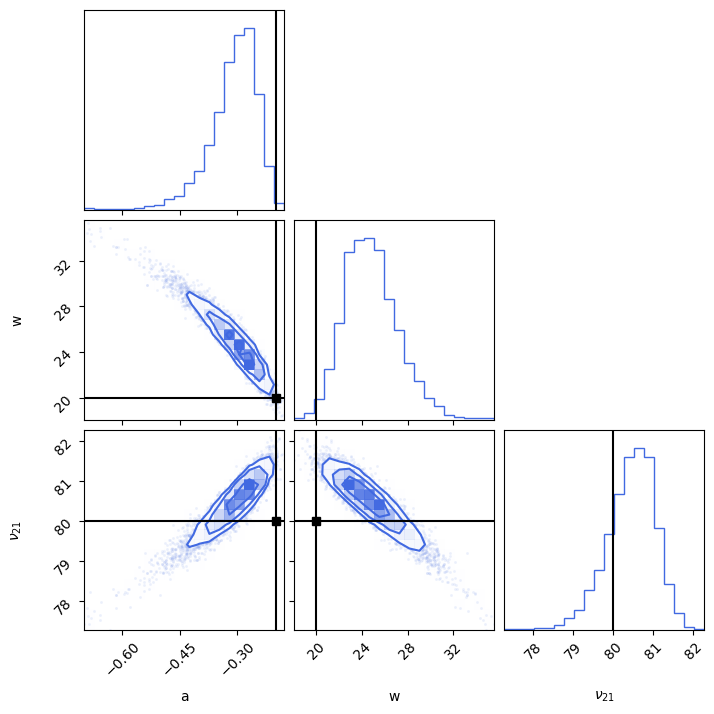

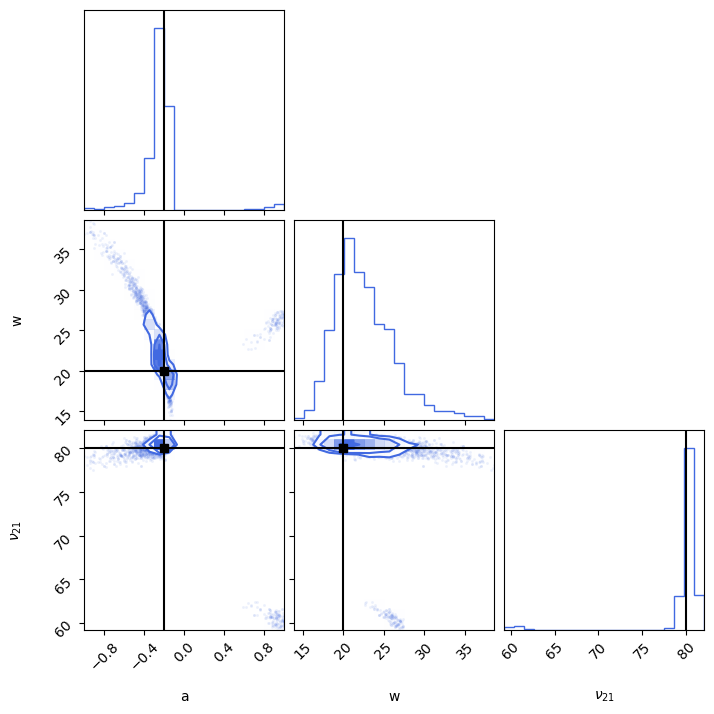

In [13]:
labels = ["a", "w", "$\\nu_{21}$"]
for n in NFG:
    _ = corner.corner(results[n]["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [14]:
def print_res(results):
    estimated_params = results["theta_map"]
    std_vals = np.std(results['samples'], axis=0)
    print('Mean values = ', estimated_params)
    print('Standard deviation values = ', std_vals)
    print()
    print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
    print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

for n in NFG:
    print_res(results[n])

Mean values =  [-0.3101351  24.83304877 80.44885598]
Standard deviation values =  [0.06350225 2.36562378 0.60802536]

[35.51197439 19.46216436  0.55793954]
[1.73434945 2.04303355 0.73821917]
Mean values =  [-0.23113315 22.630303   79.86191698]
Standard deviation values =  [0.21453489 3.69499588 3.18700371]

[13.46978929 11.62292436  0.17290222]
[0.14511928 0.71185546 0.04332691]


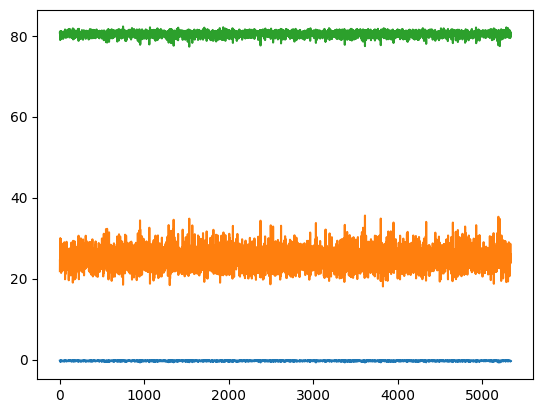

In [19]:
plt.figure()
plt.plot(results[4]["samples"])
plt.show()

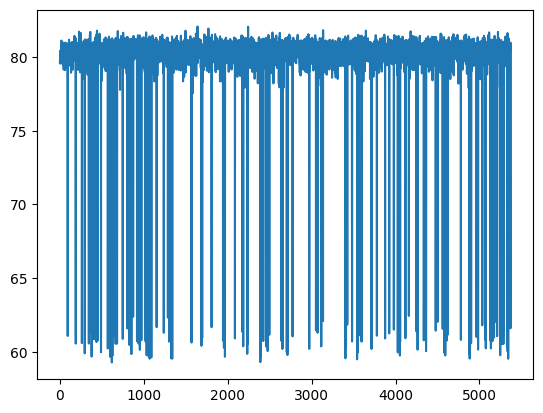

In [20]:
plt.figure()
plt.plot(results[5]["samples"][:, -1])
plt.show()

### Change pocomc params for the NFG = 5 case to get more effective samples


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, calls=250, beta=0, logZ=0]
Iter: 1it [00:00, 48.04it/s, calls=500, beta=0, logZ=0]
Iter: 2it [00:00, 71.00it/s, calls=750, beta=0, logZ=0]
Iter: 3it [00:00, 70.87it/s, calls=1000, beta=0, logZ=0]
Iter: 4it [00:00, 81.50it/s, calls=1250, beta=0, logZ=0]
Iter: 5it [00:00, 91.40it/s, calls=1500, beta=0, logZ=0]
Iter: 6it [00:00, 98.00it/s, calls=1750, beta=0, logZ=0]
Iter: 7it [00:00, 104.92it/s, calls=2000, beta=0, logZ=0]
Iter: 8it [00:00, 110.53it/s, calls=2250, beta=0, logZ=0]
Iter: 9it [00:00, 114.99it/s, calls=2500, beta=0, logZ=0]
Iter: 10it [00:00, 119.03it/s, calls=2750, beta=0, logZ=0]
Iter: 11it [00:00, 120.66it/s, calls=3000, beta=0, logZ=0]
Iter: 12it [00:00, 123.46it/s, calls=3250, beta=0, logZ=0]
Iter: 13it [00:00, 126.78it/s, calls=3500, beta=0, logZ=0]
Iter: 14it [00:00, 135.71it/s, calls=3500, beta=0, logZ=0]
Iter: 14it [00:00, 135.71it/s, calls=3750, beta=0, logZ=0]
Iter: 15it [00:00, 135.71it/s, calls=4000, beta=0, log

Mean values =  [-0.23536021 22.50317213 79.96650828]
Standard deviation values =  [0.19873924 3.77417665 2.87108508]

[15.02387023 11.12364121  0.04188218]
[0.17792265 0.66323661 0.01166518]


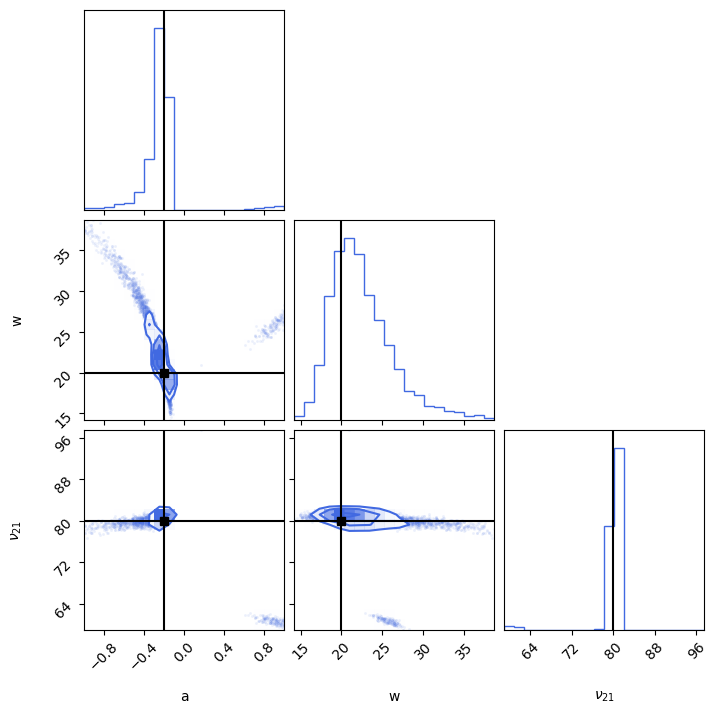

In [22]:
# n_ess from 1000 to 5000
lb = lst_bins[-1]
res = ms.run_sampler(prior, lb, progress=True, vectorize=True, pool=None, n_ess=5000)
_ = corner.corner(res["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")
print_res(res)


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, calls=400, beta=0, logZ=0]
Iter: 1it [00:00, 70.54it/s, calls=800, beta=0, logZ=0]
Iter: 2it [00:00, 84.33it/s, calls=1200, beta=0, logZ=0]
Iter: 3it [00:00, 97.32it/s, calls=1600, beta=0, logZ=0]
Iter: 5it [00:00, 139.28it/s, calls=1600, beta=0.00635, logZ=-1.34, ESS=1.01e+3]
Iter: 5it [00:05,  1.03s/it, calls=2000, beta=0.00635, logZ=-1.34, ESS=1.01e+3, acc=0.769, steps=1, logP=-163, eff=0.72]
Iter: 6it [00:05,  1.16it/s, calls=2000, beta=0.00635, logZ=-1.34, ESS=1.01e+3, acc=0.769, steps=1, logP=-163, eff=0.72]
Iter: 6it [00:05,  1.16it/s, calls=2000, beta=0.0141, logZ=-2.4, ESS=1.01e+3, acc=0.769, steps=1, logP=-163, eff=0.72]  
Iter: 6it [00:11,  1.16it/s, calls=2400, beta=0.0141, logZ=-2.4, ESS=1.01e+3, acc=0.737, steps=1, logP=-130, eff=0.72]
Iter: 6it [00:11,  1.16it/s, calls=2800, beta=0.0141, logZ=-2.4, ESS=1.01e+3, acc=0.715, steps=2, logP=-129, eff=0.72]
Iter: 6it [00:11,  1.16it/s, calls=3200, beta=0.0141, logZ=-2.4, ESS=1

Mean values =  [-0.24004628 22.47227425 80.06917378]
Standard deviation values =  [0.18420267 3.76550772 2.58569546]

[16.68273346 11.00144214  0.08639253]
[0.21740337 0.65655801 0.02675249]


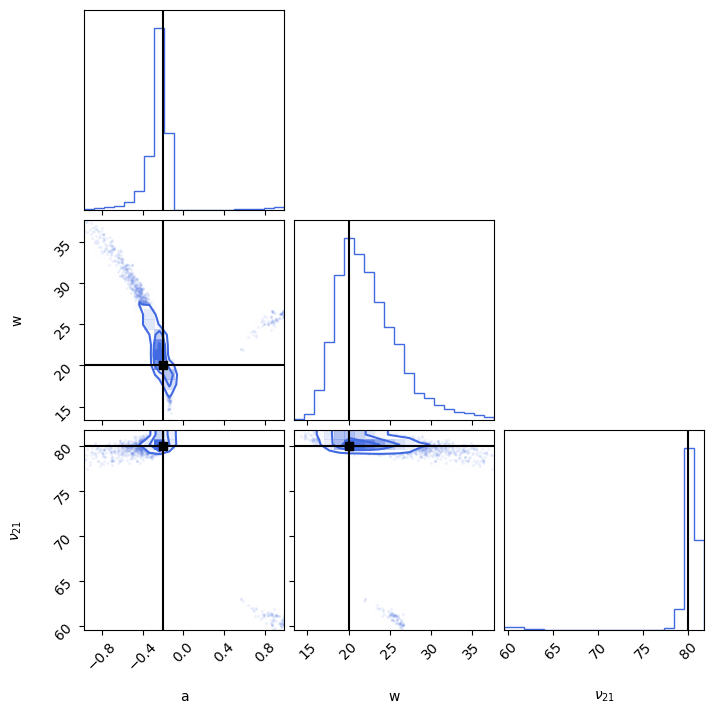

In [23]:
# n_active from 250 to 400 (should be less than n_ess//2)
res2 = ms.run_sampler(prior, lb, progress=True, vectorize=True, pool=None, n_active=400)
_ = corner.corner(res2["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")
print_res(res2)


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, calls=100, beta=0, logZ=0]
Iter: 1it [00:00, 93.10it/s, calls=200, beta=0, logZ=0]
Iter: 2it [00:00, 129.35it/s, calls=300, beta=0, logZ=0]
Iter: 3it [00:00, 152.91it/s, calls=400, beta=0, logZ=0]
Iter: 4it [00:00, 162.87it/s, calls=500, beta=0, logZ=0]
Iter: 5it [00:00, 179.35it/s, calls=600, beta=0, logZ=0]
Iter: 6it [00:00, 186.51it/s, calls=700, beta=0, logZ=0]
Iter: 7it [00:00, 191.51it/s, calls=800, beta=0, logZ=0]
Iter: 8it [00:00, 196.34it/s, calls=900, beta=0, logZ=0]
Iter: 9it [00:00, 200.23it/s, calls=1000, beta=0, logZ=0]
Iter: 10it [00:00, 202.81it/s, calls=1100, beta=0, logZ=0]
Iter: 11it [00:00, 205.46it/s, calls=1200, beta=0, logZ=0]
Iter: 12it [00:00, 207.02it/s, calls=1300, beta=0, logZ=0]
Iter: 13it [00:00, 209.01it/s, calls=1400, beta=0, logZ=0]
Iter: 14it [00:00, 210.52it/s, calls=1500, beta=0, logZ=0]
Iter: 15it [00:00, 212.25it/s, calls=1600, beta=0, logZ=0]
Iter: 16it [00:00, 214.95it/s, calls=1700, beta=0, logZ

Mean values =  [-0.23604876 22.57133465 79.93961567]
Standard deviation values =  [0.20638062 3.87795583 2.975036  ]

[15.27174459 11.39203636  0.07553742]
[0.17467126 0.66306445 0.02029701]


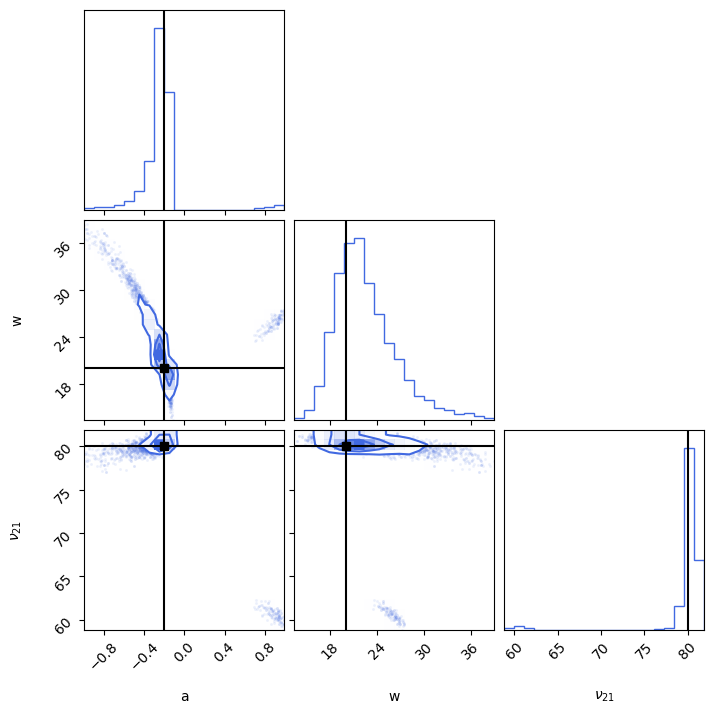

In [24]:
# n_ess to 3000 and n_active to 1000
res3 = ms.run_sampler(prior, lb, progress=True, vectorize=True, pool=None, n_ess=3000, n_active=100)
_ = corner.corner(res3["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")
print_res(res3)